# Prepare the data

This tutorial uses the [Titanic dataset](https://hbiostat.org/data/repo/titanic.html) available on [OpenML.org](OpenML.org), which is obtained from Vanderbilt University's Department of Biostatistics at [https://hbiostat.org/data](https://hbiostat.org/data). The Titanic data provides information about the survival of passengers on the Titanic, as well as characteristics about the passengers such as age and ticket class. Using this data, the tutorial will establish a model for predicting whether a given passenger would have survived the sinking of the Titanic. This section shows how to load and manipulate data in your Jupyter notebook.

Within your Jupyter notebook, begin by importing the [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/) libraries, two common libraries used for manipulating data, and loading the Titanic data into a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). For additional guidance about working with Jupyter notebooks in VS Code, see the [Working with Jupyter Notebooks](https://code.visualstudio.com/docs/datascience/jupyter-notebooks) documentation.

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('data.csv')

Before the data can be graphed, you need to make sure that there aren't any issues with it. If you look at the Titanic csv file, one thing you'll notice is that a question mark ("?") was used to designate cells where data wasn't available.

While Pandas can read this value into a DataFrame, the result for a column like Age is that its data type will be set to Object instead of a numeric data type, which is problematic for graphing.

This problem can be corrected by replacing the question mark with a missing value that pandas is able to understand. Add the following code to the next cell in your notebook to replace the question marks in the age and fare columns with the [numpy NaN](https://numpy.org/doc/stable/reference/constants.html?highlight=nan#numpy.nan) value. Notice that we also need to update the column's data type after replacing the values.

>**Tip**: To add a new cell you can use the insert cell icon that's in the bottom left corner of an existing cell. Alternatively, you can also use the `Esc` to enter command mode, followed by the `B` key.

In [3]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

>**Note**: If you ever need to see the data type that has been used for a column, you can use the [DataFrame dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html#pandas.DataFrame.dtypes) attribute.

Now that the data is in good shape, you can use [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) to view how certain columns of the dataset relate to survivability.

<AxesSubplot:xlabel='survived', ylabel='fare'>

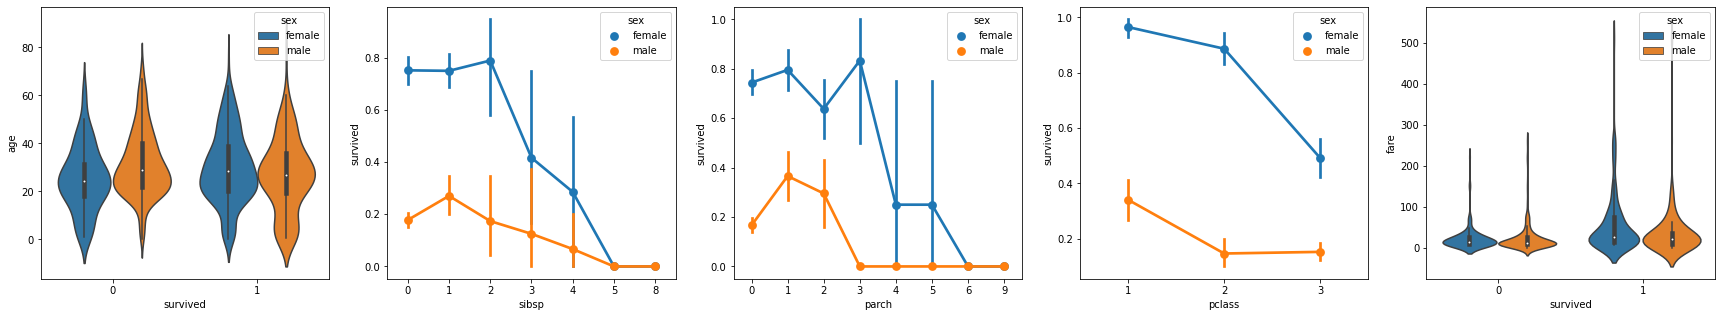

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

To better view details on the graphs, you can open them in the plot viewer by hovering over the upper right corner of the graph and clicking the button that appears.

These graphs are helpful in seeing some of the relationships between survival and the input variables of the data, but it's also possible to use **pandas** to calculate correlations. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string. 

In [5]:
data.replace({'male': 1, 'female': 0}, inplace=True)

Now, you can analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result. Use the following code to correlate the relationship between all variables and survival

In [6]:
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


Looking at the correlation results, you'll notice that some variables like gender have a fairly high correlation to survival, while others like relatives (sibsp = siblings or spouse, parch = parents or children) seem to have little correlation.

Let's hypothesize that **sibsp** and **parch** are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. To do this, you will check if for a given passenger, the number of **sibsp** and **parch** is greater than 0 and, if so, you can then say that they had a `relative` on board.

Use the following code to create a new variable and column in the dataset called relatives and check the correlation again.

In [7]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


You'll notice that in fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, you can now drop from the dataset the low value **sibsp** and **parch** columns, as well as any rows that had **NaN** values, to end up with a dataset that can be used for training a model.



In [8]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

>**Note**: Although age had a low direct correlation, it was kept because it seems reasonable that it might still have correlation in conjunction with other inputs.



# Train and evaluate a model

With the dataset ready, you can now begin creating a model. For this section you'll use the [scikit-learn](https://scikit-learn.org/stable/) library (as it offers some useful helper functions) to do pre-processing of the dataset, train a classification model to determine survivability on the Titanic, and then use that model with test data to determine its accuracy.


<li> 1. A common first step to training a model is to divide up the dataset into training and validation data. This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model has not yet seen. A benefit of the scikit-learn library is that it provides a method specifically for splitting a dataset into training and test data.
</li>

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

<li>2. Next, you'll normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing all the variables, you can ensure that the ranges of values are all the same. </li>

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

<li>3. There are a number of different machine learning algorithms that you could choose from to model the data and scikit-learn provides support for a number of [them](https://scikit-learn.org/stable/user_guide.html), as well as a [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help select the one that's right for your scenario. For now, use the [Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) algorithm, a common algorithm for classification problems. </li>

In [11]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

<li>4. With a trained model, you can now try it against the test data set that was held back from training. Add and run the following code to predict the outcome of the test data and calculate the accuracy of the model.</li>


In [12]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


Looking at the result of the test data, you'll see that the trained algorithm had a ~75% success rate at estimating survival.